In [1]:
import glob
import os
import random
import shutil
from operator import itemgetter
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

# from PIL import Image
import numpy as np
from matplotlib.patches import Rectangle

# import xml.etree.ElementTree as ET
from pascal import annotation_from_xml
from pylabel import importer
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import utils

In [3]:
RAND_SEED = 42
random.seed(RAND_SEED)

In [4]:
root_dir = Path(os.getcwd()).parent
data_dir = root_dir/"data"
raw_data_dir = data_dir/"0_raw"
processed_data_dir = data_dir/"1_processed"

try:
    raw_data_dir.mkdir(exist_ok=False)
except:
    pass

try:
    processed_data_dir.mkdir(exist_ok=False)
except:
    pass

# RDDC2020 Data

In [5]:
# name_mapping = {
#     0:'longitudinal_crack',
#     10:'traverse_crack',
#     20:'alligator_crack',
#     40:'pothole',
#     44:'whiteline_blur',
#     43:'crosswalk_blur',
#     50:'utility'
# }
excluded_classes = ['1','11','43','44','50']

class_simplify = {
    '0':'0',
    '10':'1',
    '20':'2',
    '40':'3'
}

In [6]:
excluded_country = ["Norway", "China", "Czech"]
subfolders = glob.glob(str(raw_data_dir/"sekilab*"))

used_subfolders = [folder for folder in subfolders if all(exclude not in folder for exclude in excluded_country)]
used_subfolders

['d:\\0_amri_local\\14_pupr_roaddamagedetection\\yolov8_custom\\data\\0_raw\\sekilab_India',
 'd:\\0_amri_local\\14_pupr_roaddamagedetection\\yolov8_custom\\data\\0_raw\\sekilab_Japan',
 'd:\\0_amri_local\\14_pupr_roaddamagedetection\\yolov8_custom\\data\\0_raw\\sekilab_United_States']

In [7]:
pascal_train_annotation_result = processed_data_dir/"train"
pascal_valid_annotation_result = processed_data_dir/"valid"

try:
    pascal_train_annotation_result.mkdir(exist_ok=False)
    (pascal_train_annotation_result / "images").mkdir(exist_ok=False)
    (pascal_train_annotation_result / "labels").mkdir(exist_ok=False)
except:
    pass

try:
    pascal_valid_annotation_result.mkdir(exist_ok=False)
    (pascal_valid_annotation_result / "images").mkdir(exist_ok=False)
    (pascal_valid_annotation_result / "labels").mkdir(exist_ok=False)
except:
    pass

In [8]:
for subfolder in used_subfolders:
    location_name = subfolder.split("\\")[-1]
    annotation_source = Path(rf"{subfolder}\train\annotations\xmls")
    image_dir = Path(subfolder) / "train" / "images"
    
    dataset = importer.ImportVOC(path=annotation_source)
    class_mapping = {classes: int(classes[1:]) for classes in dataset.analyze.classes if len(classes)==3}
    
    print("creating image and label list....")
    image_list = glob.glob(str(image_dir / "*.jpg"))
    xml_list = glob.glob(str(annotation_source / "*.xml"))
    
    print("split into training and validation...")
    training_ratio = .8
    if not os.path.exists(Path(subfolder) /f'{location_name}_train_index.txt'):
        random_index = random.sample(
            np.arange(len(image_list)).tolist(),
            int(len(image_list)*training_ratio)
        )
        with open(str(Path(subfolder) /f'{location_name}_train_index.txt'), 'w') as f:
            for line in random_index:
                f.write(f"{line}\n")
    else:
        with open(str(Path(subfolder) /f'{location_name}_train_index.txt'), 'r') as lines:
            random_index = [int(line.strip()) for line in lines]
            lines.close()
    
    getter = itemgetter(*random_index)

    train_image_list = list(getter(image_list))
    valid_image_list = [item for item in image_list if item not in train_image_list]

    train_xml_list = list(getter(xml_list))
    valid_xml_list = [item for item in xml_list if item not in train_xml_list]
    
    print("convert and reorg training....")
    for xml, img in tqdm(zip(train_xml_list, train_image_list), total=len(train_image_list)):
        utils.convert_and_reorg(xml, img, pascal_train_annotation_result, class_mapping, copy=True)
        
    print("convert and reorg validation....")
    for xml, img in tqdm(zip(valid_xml_list, valid_image_list), total=len(valid_image_list)):
        utils.convert_and_reorg(xml, img, pascal_valid_annotation_result, class_mapping, copy=True)

Importing VOC files...: 100%|██████████| 7706/7706 [00:11<00:00, 646.67it/s]


creating image and label list....
split into training and validation...
convert and reorg training....


  0%|          | 0/6164 [00:00<?, ?it/s]

convert and reorg validation....


  0%|          | 0/1542 [00:00<?, ?it/s]

Importing VOC files...: 100%|██████████| 10506/10506 [00:18<00:00, 555.37it/s]


creating image and label list....
split into training and validation...
convert and reorg training....


  0%|          | 0/8404 [00:00<?, ?it/s]

convert and reorg validation....


  0%|          | 0/2102 [00:00<?, ?it/s]

Importing VOC files...: 100%|██████████| 4805/4805 [00:09<00:00, 489.95it/s]


creating image and label list....
split into training and validation...
convert and reorg training....


  0%|          | 0/3844 [00:00<?, ?it/s]

convert and reorg validation....


  0%|          | 0/961 [00:00<?, ?it/s]

In [9]:
print("remove unncecessary training label....")
for txt in tqdm(glob.glob(str(pascal_train_annotation_result / "labels" / "*.txt"))):
    utils.remove_ann_classes(txt, excluded_classes)

    # delete txt files with no annotation
    if not os.path.getsize(txt):
        os.remove(txt)
        img_name = txt.split("\\")[-1].split(".")[0]
        img_path = pascal_train_annotation_result / "images" / (img_name+".jpg")
        os.remove(img_path)

print("remove unncecessary validation label....")
for txt in tqdm(glob.glob(str(pascal_valid_annotation_result / "labels" / "*.txt"))):
    utils.remove_ann_classes(txt, excluded_classes)
    
    # delete txt files with no annotation
    if not os.path.getsize(txt):
        os.remove(txt)
        img_name = txt.split("\\")[-1].split(".")[0]
        img_path = pascal_valid_annotation_result / "images" / (img_name+".jpg")
        os.remove(img_path)

remove unncecessary training label....


  0%|          | 0/18412 [00:00<?, ?it/s]

remove unncecessary validation label....


  0%|          | 0/4605 [00:00<?, ?it/s]

In [10]:
print("remapping training label....")
for txt in tqdm(glob.glob(str(pascal_train_annotation_result / "labels" / "*.txt"))):
    utils.class_remap(txt, class_simplify)

print("remapping validation label....")
for txt in tqdm(glob.glob(str(pascal_valid_annotation_result / "labels" / "*.txt"))):
    utils.class_remap(txt, class_simplify)

remapping training label....


  0%|          | 0/12719 [00:00<?, ?it/s]

remapping validation label....


  0%|          | 0/3209 [00:00<?, ?it/s]

In [11]:
label_naming = {
    0: "retak_memanjang",
    1: "retak_melintang",
    2: "retak_buaya",
    3: "pothole"
}

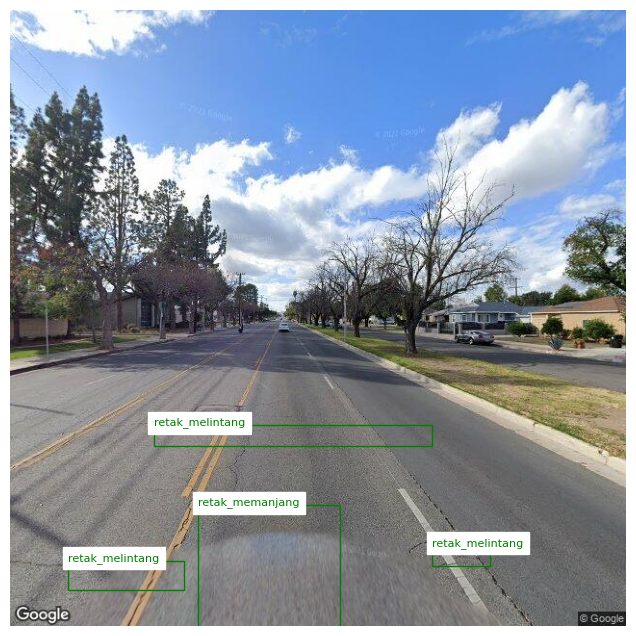

In [13]:
new_label_list = glob.glob(str(processed_data_dir / "train/labels" / "*.txt"))
temp_label = random.sample(new_label_list, 1)[0]
temp_label_name = temp_label.split("\\")[-1].split(".")[0]
temp_image = Path(temp_label).parent.parent / "images" / (temp_label_name+".jpg")

image = cv2.imread(str(temp_image))

annotation_data = []
with open(temp_label, 'r') as label_file:
    for line in label_file:
        parts = line.strip().split()
        label, x, y, width, height = map(float, parts)
        annotation_data.append((label, x, y, width, height))

# Set the figure size
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

for label, x, y, width, height in annotation_data:
    x1, y1 = int(x * image.shape[1]), int(y * image.shape[0])
    rect_width, rect_height = int(width * image.shape[1]), int(height * image.shape[0])
    rect = Rectangle((x1, y1), rect_width, rect_height, linewidth=1, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(x1, y1, label_naming[int(label)], fontsize=8, color='g', backgroundcolor='w')

plt.axis('off')
plt.show()

# Additional Data

In [5]:
additional_mapping = {
    '0':'2',
    '1':'1',
    '2':'0',
    '3':'3',
}

In [6]:
additional_folder = glob.glob(str(raw_data_dir / "additional*"))

In [7]:
addit_train_source = Path(additional_folder[0]) / "train"
addit_valid_source = Path(additional_folder[0]) / "valid"

In [15]:
for dir in tqdm(os.listdir(addit_train_source)):
    print(f"working on {dir}")
    dest_dir = processed_data_dir / "train" / dir
    for item in tqdm(glob.glob(str(addit_train_source / dir / "*"))):
        item_name = os.path.basename(item)
        addit_item_path = dest_dir / ("addit_" + item_name)

        if not os.path.exists(addit_item_path):
            shutil.copy(item, dest_dir / item_name)
            os.rename(dest_dir / item_name, addit_item_path)

  0%|          | 0/2 [00:00<?, ?it/s]

working on images


  0%|          | 0/2657 [00:00<?, ?it/s]

working on labels


  0%|          | 0/2657 [00:00<?, ?it/s]

In [16]:
for dir in tqdm(os.listdir(addit_valid_source)):
    print(f"working on {dir}")
    dest_dir = processed_data_dir / "valid" / dir
    for item in tqdm(glob.glob(str(addit_valid_source / dir / "*"))):
        item_name = os.path.basename(item)
        addit_item_path = dest_dir / ("addit_" + item_name)

        if not os.path.exists(addit_item_path):
            shutil.copy(item, dest_dir / item_name)
            os.rename(dest_dir / item_name, addit_item_path)

  0%|          | 0/2 [00:00<?, ?it/s]

working on images


  0%|          | 0/664 [00:00<?, ?it/s]

working on labels


  0%|          | 0/664 [00:00<?, ?it/s]

In [20]:
addit_txt_train = list((processed_data_dir / "train" / "labels" ).glob("addit*.txt"))
for txt in tqdm(addit_txt_train):
    utils.class_remap(txt, additional_mapping)

  0%|          | 0/2657 [00:00<?, ?it/s]

In [21]:
addit_txt_valid = list((processed_data_dir / "valid" / "labels" ).glob("addit*.txt"))
for txt in tqdm(addit_txt_valid):
    utils.class_remap(txt, additional_mapping)

  0%|          | 0/664 [00:00<?, ?it/s]

# PUPR Roboflow

In [5]:
pupr_mapping = {
    '0':'2',
    '1':'1',
    '2':'0',
    '3':'3',
}

In [ ]:
pupr_folder = glob.glob(str(raw_data_dir / "pupr*"))

In [ ]:
pupr_train_source = Path(pupr_folder[0]) / "train"
pupr_valid_source = Path(pupr_folder[0]) / "valid"

In [ ]:
for dir in tqdm(os.listdir(pupr_train_source)):
    print(f"working on {dir}")
    dest_dir = processed_data_dir / "train" / dir
    for item in tqdm(glob.glob(str(pupr_train_source / dir / "*"))):
        item_name = os.path.basename(item)
        pupr_item_path = dest_dir / ("pupr_" + item_name)

        if not os.path.exists(pupr_item_path):
            shutil.copy(item, dest_dir / item_name)
            os.rename(dest_dir / item_name, pupr_item_path)

  0%|          | 0/2 [00:00<?, ?it/s]

working on images


  0%|          | 0/2657 [00:00<?, ?it/s]

working on labels


  0%|          | 0/2657 [00:00<?, ?it/s]

In [ ]:
for dir in tqdm(os.listdir(pupr_valid_source)):
    print(f"working on {dir}")
    dest_dir = processed_data_dir / "valid" / dir
    for item in tqdm(glob.glob(str(pupr_valid_source / dir / "*"))):
        item_name = os.path.basename(item)
        pupr_item_path = dest_dir / ("pupr_" + item_name)

        if not os.path.exists(pupr_item_path):
            shutil.copy(item, dest_dir / item_name)
            os.rename(dest_dir / item_name, pupr_item_path)

In [ ]:
pupr_txt_train = list((processed_data_dir / "train" / "labels" ).glob("pupr*.txt"))
for txt in tqdm(pupr_txt_train):
    utils.class_remap(txt, pupr_mapping)

In [ ]:
pupr_txt_valid = list((processed_data_dir / "valid" / "labels" ).glob("pupr*.txt"))
for txt in tqdm(pupr_txt_valid):
    utils.class_remap(txt, pupr_mapping)

# Placeholder